<a href="https://colab.research.google.com/github/Soomro2023/Project5/blob/main/Weekly_trading_Sberbank.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading data

In [1]:
from google.colab import files
upload = files.upload()

Saving 2020Q1Q2Q3Q4-2021Q1.xlsx to 2020Q1Q2Q3Q4-2021Q1.xlsx


# Importing dependencies

In [2]:
#dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings('ignore')


# Data Exploration

In [3]:
#read excel file
df  = pd.ExcelFile('2020Q1Q2Q3Q4-2021Q1.xlsx')
df = df.parse(0)
data_name = 'Sberbank'

In [4]:
df.head(5)

,Date,Price,Open,High,Low,Vol.,Change %
0,2021-03-31 00:00:00,291.02,294,294.42,290.26,47.00M,-0.0076
1,2021-03-30 00:00:00,293.25,294.86,295.72,291.5,38.81M,-0.0002
2,2021-03-29 00:00:00,293.3,289.72,294.09,289.26,43.68M,0.0071
3,2021-03-26 00:00:00,291.22,288.63,292.75,288.32,56.07M,0.0159
4,2021-03-25 00:00:00,286.66,286.5,287.03,283.85,35.22M,0.0030


In [5]:
df.tail(5)

,Date,Price,Open,High,Low,Vol.,Change %
307,2020-01-09 00:00:00,257.99,259.4,261.76,257.01,38.33M,-0.0045
308,2020-01-08 00:00:00,259.15,253.57,259.15,253.03,40.82M,0.0207
309,2020-01-06 00:00:00,253.9,254.75,254.84,251.4,22.35M,-0.0043
310,2020-01-03 00:00:00,255,255.99,258.19,253.7,35.85M,0.0010
311,Highest: 296.07,Lowest: 172.15,Difference: 123.92,Average: 234.52,Change %: 14.24,NaN,NaN


In [6]:
df = df[:-1] #deleting the last row as it is just providing statistics
df = df[::-1] #sorting the order so that 2020 appears first
df = df.reset_index()

#dropping volume and change % as they will not be used for the prediction
df = df.drop(columns = ['Vol.', 'Change %'])

#checking for null values
null_values = df.isnull().values.any()
if null_values:
    df = df.dropna(axis=0)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   311 non-null    int64 
 1   Date    311 non-null    object
 2   Price   311 non-null    object
 3   Open    311 non-null    object
 4   High    311 non-null    object
 5   Low     311 non-null    object
dtypes: int64(1), object(5)
memory usage: 14.7+ KB


In [8]:
#removing comma
df['Price'] = df['Price'].astype(str).str.extract(r'([^,]+)')
df['Open'] = df['Open'].astype(str).str.extract(r'([^,]+)')
df['High'] = df['High'].astype(str).str.extract(r'([^,]+)')
df['Low'] =  df['Low'].astype(str).str.extract(r'([^,]+)')

#changing dtype of columns to float
df['Price'] = pd.to_numeric(df['Price'])
df['Open'] = pd.to_numeric(df['Open'])
df['High'] = pd.to_numeric(df['High'])
df['Low'] = pd.to_numeric(df['Low'])

In [9]:
df.describe()

,index,Price,Open,High,Low
count,311.000000,311.000000,311.000000,311.000000,311.000000
mean,155.000000,234.524019,234.417846,237.314759,231.366141
std,89.922189,32.079847,32.058167,32.075624,32.076603
min,0.000000,174.270000,175.000000,182.200000,172.150000
25%,77.500000,207.700000,207.215000,209.660000,204.475000
50%,155.000000,229.140000,229.080000,231.950000,226.860000
75%,232.500000,264.380000,263.885000,267.255000,261.110000
max,310.000000,293.300000,294.860000,296.070000,291.500000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   311 non-null    int64  
 1   Date    311 non-null    object 
 2   Price   311 non-null    float64
 3   Open    311 non-null    float64
 4   High    311 non-null    float64
 5   Low     311 non-null    float64
dtypes: float64(4), int64(1), object(1)
memory usage: 14.7+ KB


# Spliting data into train, validation and test datasets

In [11]:
#converting the date to Timestamp format
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

#splitting the dataframe into training and test dataset
df['year'] = df['Date'].dt.year
df_train = df[df['year'] == 2020]
df_test = df[df['year'] == 2021]

#getting the weekly closing price from training and test dataframe
price_train = []
date_train = []
price_test = []
date_test = []

for key,item in df.groupby(df_train.Date.dt.strftime('%W')):
    price_train.append(item['Price'].iloc[-1])
    date_train.append(item['Date'].iloc[-1])

for key,item in df.groupby(df_test.Date.dt.strftime('%W')):
    price_test.append(item['Price'].iloc[-1])
    date_test.append(item['Date'].iloc[-1])

#creating the dataframe
df_weekly_train = pd.DataFrame(list(zip(date_train, price_train)), columns=['Date','Price'])
df_weekly_test = pd.DataFrame(list(zip(date_test, price_test)), columns=['Date','Price'])

#goal here is to split the data into train and test dataframe using end of 2020 as the boundary to slice the dataframe
#finding the train-test boundary
df = pd.concat([df_weekly_train, df_weekly_test])
df['Year'] = pd.DatetimeIndex(df['Date']).year
train_test_boundary = df[df['Year'] == 2020].index[-1] #extracting the index of where 2020 data finishes

date_arr = df['Date'].to_numpy() #storing date as we would need this at a later point

#setting date as index
df = df.set_index('Date')

#removing the Year column
df = df.drop(columns = ['Year'])

#normalize the data
scaler = MinMaxScaler()
cols = df.columns
df[cols] = scaler.fit_transform(df[cols])

#defining the training dataframe
train_df = df[:train_test_boundary+1]

#defining the testing dataframe
test_df = df[train_test_boundary+1:]



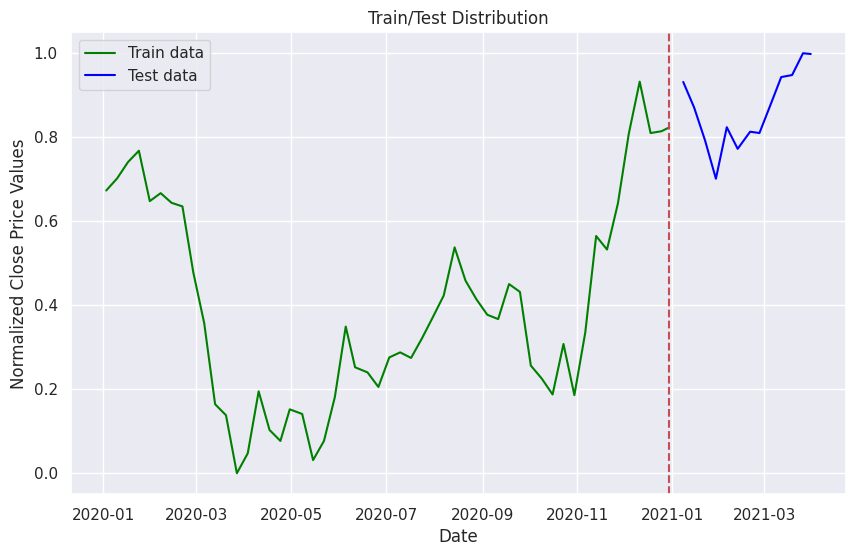

In [12]:
sns.set()
#plot the distribution of train and test
plt.figure(figsize=(10,6))
# plt.grid(True)
plt.xlabel("Date")
plt.ylabel("Normalized Close Price Values")
plt.plot(train_df.index, train_df['Price'], 'green', label='Train data')
plt.plot(test_df.index, test_df['Price'], 'blue', label='Test data')
plt.axvline(x=df.index[train_test_boundary], linestyle='dashed', color='r')

plt.title("Train/Test Distribution")
plt.legend()





# Training the model

In [13]:
n_steps = 1
n_features = 1

# split a univariate sequence into samples
# for example if we had a data such as [10, 20, 30, 40, 50]
# and if n_step was 3
# then feature will be [[10, 20, 30], [20, 30, 30]]
# and label will be [[40], [50]]
# logic of this approach can be found here - machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting
def split_sequence(data, n_steps):
    X, y = list(), list()
    for i in range(len(data)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(data)-1:
            break
        # gather input and output parts of the pattern
        seq_x_price = data['Price'].iloc[i:end_ix]
        seq_y = data['Price'].iloc[end_ix]
        x = np.empty((1,n_features))
        for idx in range(n_steps):
            x[idx, 0] = seq_x_price[idx]
        y.append(seq_y)
        X.append(x)
    return np.array(X), np.array(y)

ratio = len(train_df) * 0.9
X_val_df = train_df.iloc[int(ratio):]
X_train_df = train_df.iloc[:int(ratio)]

# multivariate_y_val = y_train.iloc[int(ratio):]
# multivariate_y_train = y_train.iloc[:int(ratio)]

#creating training set and labels with a n_step of 3
X_train, y_train = split_sequence(X_train_df, n_steps)

#creating training set and labels with a n_step of 3
X_val, y_val = split_sequence(X_val_df, n_steps)

#creating training set and labels with a n_step of 3
X_test, y_test = split_sequence(test_df, n_steps)

In [14]:
# Set a seed value
seed_value= 12321


def find_mae(y_true, y_pred):
    """
    return the mean absolute error
    """
    return mean_absolute_error(y_true, y_pred)




def train_valid_loss(hist, data_name, model_name):
    """
    param hist: output from deep NN like LSTM, and it contains both train and val loss scores.
    param data_name: used to naming the title figures.
    This function will return Train VS. Valid Loss plot.
    """
    plt.figure(figsize=(16, 5))
    plt.plot(hist.history['loss'], label='Train loss', linewidth=1.5)
    plt.plot(hist.history['val_loss'], label='Valid loss', linewidth=1.5)
    plt.title(f'Train VS. Valid Loss for {model_name}', fontsize=20)
    plt.legend();

def LSTM(X_train, y_train, X_val, y_val, X_test, y_test, n_features, data_name):
    """
    This function will use the LSTM and return both of the model name as well as the mean square error score to
    add it later to dict.
    """
    # adjust the seeds
    tf.random.set_seed(seed_value)

    # because we will use the LSTM with one and later with multiple features we need to define the model name to save it.

    model_name = f"{data_name} Multivariate LSTM Model"

    # 1) Create the model
    model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=100, activation='relu', input_shape=(X_train.shape[1], n_features)),
    tf.keras.layers.Dense(units=1)])

    # 2) Compile the model
    model.compile(loss=tf.keras.metrics.mae, optimizer=tf.keras.optimizers.Adam())

    # 3) Fit the model
    callbacks = [
        EarlyStopping(monitor='val_loss', mode='min',patience=50),
        ModelCheckpoint(f'output/models/{model_name}.h5', verbose=0, save_best_only=True)]
    hist = model.fit(X_train, y_train, epochs =5000, batch_size=16, validation_data=(X_val, y_val), callbacks=[callbacks], verbose=0)

    # 4) plot the train and val loss scores
    train_valid_loss(hist, data_name, model_name)

    # 5) find the predictions
    predictions = model.predict(X_test)
    # predictions = np.roll(predictions, -1)
    # 6) find the mean square error score
    mae = find_mae(y_test, predictions)
    # 7) plot the actual vs. predicted price
    # actual_prediction_plot(y_test, predictions, data_name, model_name)


    return model_name, mae, predictions

def scores(scores_dict):
    return pd.DataFrame(scores_dict)



def multivariate_LSTM(data_name, X_train, y_train, X_val, y_val, X_test, y_test, scores_dict):
    """
    return the multivariate LSTM moled result
    """



    multivariate_LSTM_X_train, multivariate_LSTM_y_train =  X_train, y_train
    multivariate_LSTM_X_val, multivariate_LSTM_y_val =  X_val, y_val
    multivariate_LSTM_X_test, multivariate_LSTM_y_test =  X_test, y_test

    multivariate_LSTM_model_name, multivariate_LSTM_model_mae, multivariate_LSTM_y_pred = LSTM(multivariate_LSTM_X_test, multivariate_LSTM_y_test, multivariate_LSTM_X_val, multivariate_LSTM_y_val, multivariate_LSTM_X_test, multivariate_LSTM_y_test, 1, data_name)
    scores_dict['Model'].append(multivariate_LSTM_model_name)
    scores_dict['Test Score'].append(multivariate_LSTM_model_mae)

    return multivariate_LSTM_model_name, multivariate_LSTM_y_pred

def models_report(X_train, y_train, X_val, y_val, X_test, y_test, data_name):


    #Create a scoring data frame and functiont to add score
    scores_dict = {"Model":[],"Test Score":[]}

    multivariate_LSTM_model_name, multivariate_LSTM_y_pred = multivariate_LSTM(data_name, X_train, y_train, X_val, y_val, X_test, y_test, scores_dict)


    return scores_dict, multivariate_LSTM_model_name, multivariate_LSTM_y_pred

1/1 [==============================] - 0s 182ms/step


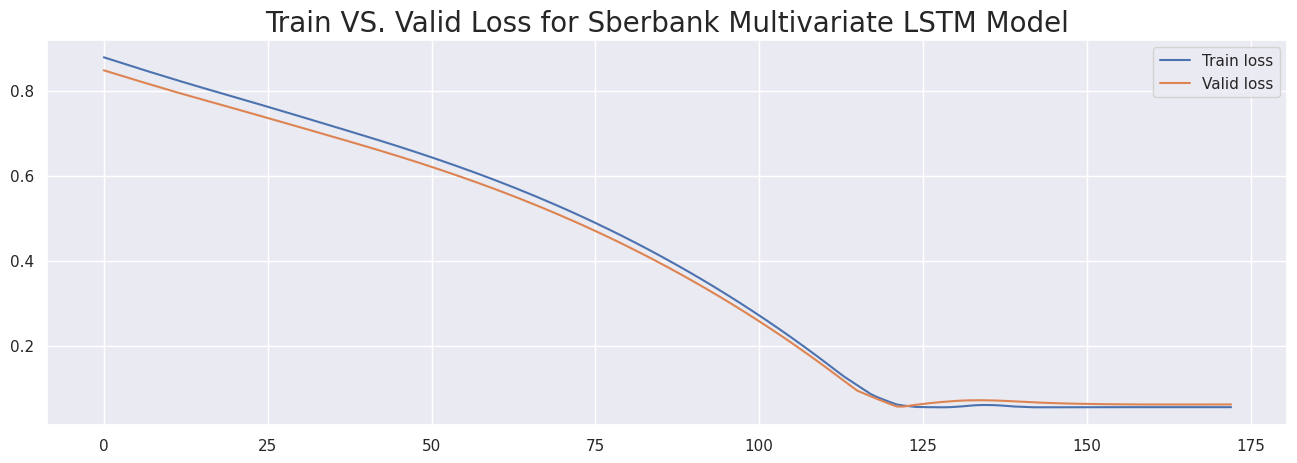

In [15]:
score, model_name, predictions = models_report(X_train, y_train, X_val, y_val, X_test, y_test, data_name)

# Ploting the prediction vs. test dataset

In [16]:
def actual_prediction_plot(actual, prediction, data_name, model_name):
    """
    param actual: is the real test price data.
    param prediction: the model prediction by using the actual test data.
    param data_name: used to naming the title figures.
    param model_name: to add the model with it's score to a dict
    This function will return Actual  VS. Predicted Price plot.
    """



    preds = pd.DataFrame()
    preds['Actual Price'], preds['Predicted Price'], preds['Date'] = actual, prediction, test_df.index[:-1]
    preds = preds.set_index('Date')
    ax = preds[['Actual Price', 'Predicted Price']].plot(figsize=(12,8),title = f'Actual Price VS. Predicted Price for {model_name}')
    ax.autoscale(axis='Date',tight=True)
    return preds

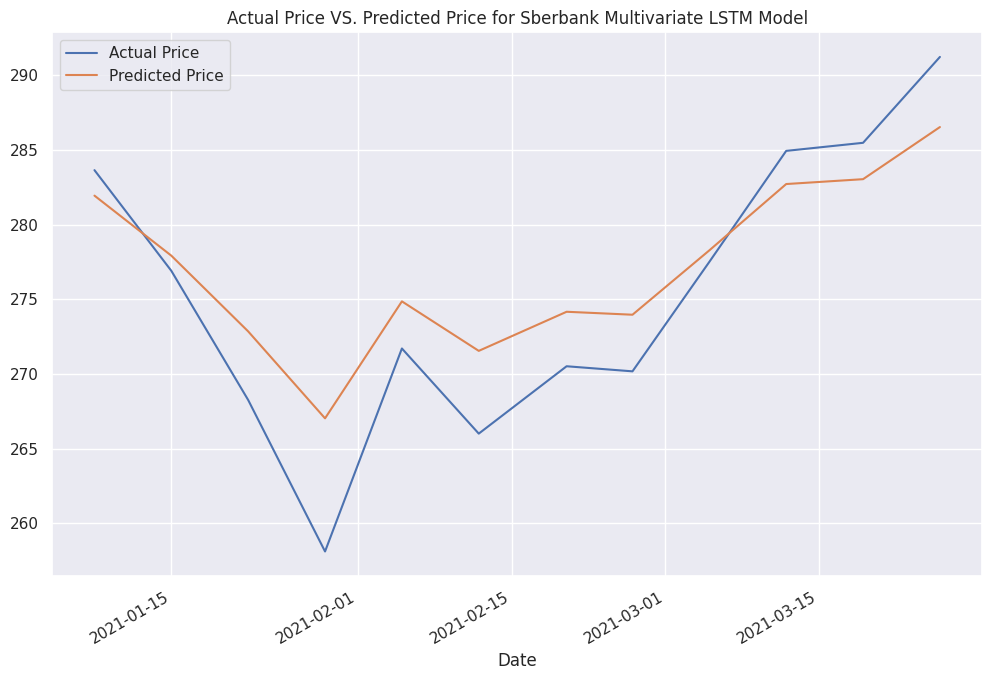

In [17]:
preds = np.append(predictions, np.zeros((predictions[:, 0].shape[0], 3)), axis=1)
preds = scaler.inverse_transform(preds)[:,0]
actual = scaler.inverse_transform(test_df)[:-1,0]
df_final = actual_prediction_plot(actual, preds, 'Sberbank', model_name)

In [18]:
df_final

,Actual Price,Predicted Price
Date,,
2021-01-08,283.64,281.933581
2021-01-15,276.90,277.914278
2021-01-22,268.25,272.843140
2021-01-29,258.11,267.022976
2021-02-05,271.70,274.853985
2021-02-12,266.00,271.540085
2021-02-20,270.51,274.158636
2021-02-26,270.17,273.960293
2021-03-05,277.50,278.269659


# Computing mean absolute error (MAE) score between prediction and test data

In [19]:
error = find_mae(df_final['Actual Price'], df_final['Predicted Price'])
mae = pd.DataFrame()
mae['MAE Score'] = [error]
mae

,MAE Score
0,3.539971


# Computing Bollinger Bands

In [20]:
#bollinger bands calculation
def sma(data, window):
    sma = data.rolling(window = window).mean()
    return sma

def bb(data, sma, window):
    std = data.rolling(window = window).std()
    upper_bb = sma + std * 2
    lower_bb = sma - std * 2
    return upper_bb, lower_bb


def implement_bb_strategy(data):

    df = data.copy()
    buy_signal = []
    sell_signal = []
    hold_signal = []
    bb_signal = []
    # signal = 0

    for i in range(len(df['Predicted Price'])):
        if df['Predicted Price'].values[i] > df['upper_bb'].values[i]: #Then you should sell
            buy_signal.append(np.nan)
            sell_signal.append(df['Predicted Price'][i])
            hold_signal.append(np.nan)
            bb_signal.append(-1)
        elif df['Predicted Price'].values[i] < df['lower_bb'].values[i]: #Then you should buy
            sell_signal.append(np.nan)
            buy_signal.append(df['Predicted Price'][i])
            hold_signal.append(np.nan)
            bb_signal.append(1)
        else:
            buy_signal.append(np.nan)
            sell_signal.append(np.nan)
            hold_signal.append(df['Predicted Price'][i]) #Then you should hold
            bb_signal.append(0)

    return buy_signal, sell_signal, hold_signal, bb_signal

# Finding the best sma and Bollinger bands parameter that give the highest return

In [31]:
investment_returns = []
sma_params = []
bb_params = []

for sma_param in np.linspace(5, 50, 10).astype(int):
    df_final = df_final.copy()
    df_final['sma_20'] = sma(df_final['Predicted Price'], sma_param)
    for bb_param in np.linspace(5, 50, 10).astype(int):
        df_final['upper_bb'], df_final['lower_bb'] = bb(df_final['Predicted Price'], df_final['sma_20'], bb_param)
        # buy_price, sell_price, bb_signal = implement_bb_strategy(df_final['Predicted Price'], df_final['lower_bb'], df_final['upper_bb'])
        buy_price, sell_price, hold_price, bb_signal = implement_bb_strategy(df_final)
        buy_price.insert(0, None)
        sell_price.insert(0, None)
        bb_signal.insert(0, None)


        position = []
        for i in range(len(bb_signal)):
            if bb_signal[i] == None:
                position.append(None)
                continue
            if bb_signal[i] > 1:
                position.append(0)
            else:
                position.append(1)

        for i in range(len(df_final['Predicted Price'])):
            if bb_signal[i] == None:
                continue
            if bb_signal[i] == 1:
                position[i] = 1
            elif bb_signal[i] == -1:
                position[i] = 0
            else:
                position[i] = position[i-1]

        upper_bb = df_final['upper_bb']
        lower_bb = df_final['lower_bb']
        close_price = df_final['Predicted Price']

        bb_signal = pd.DataFrame(bb_signal[:-1]).rename(columns = {0:'bb_signal'}).set_index(df_final.index)
        position = pd.DataFrame(position[:-1]).rename(columns = {0:'bb_position'}).set_index(df_final.index)

        frames = [close_price, upper_bb, lower_bb, bb_signal, position]
        strategy = pd.concat(frames, join = 'inner', axis = 1)

        #backtesting on actual price
        price_diff = np.diff(df_final['Actual Price'])
        list(price_diff).insert(0, None)
        df_final_ret = pd.DataFrame(price_diff).rename(columns = {0:'returns'})
        bb_strategy_ret = []

        for i in range(len(df_final_ret)):
            try:
                returns = df_final_ret['returns'][i]*strategy['bb_position'][i]
                bb_strategy_ret.append(returns)
            except:
                bb_strategy_ret.append(np.nan)

        bb_strategy_ret.insert(0, None)
        bb_strategy_ret_df = pd.DataFrame(bb_strategy_ret).rename(columns = {0:'bb_returns'})
        bb_strategy_ret_df

        investment = 1000000
        stocks = 0

        for i in range(len(bb_strategy_ret_df['bb_returns'])):
            if str(strategy['bb_signal'].iloc[i]) == 'NaN':
                continue
            if strategy['bb_signal'].iloc[i] == 1:
                stocks = int(investment/df_final['Actual Price'].iloc[i])
            returns = stocks * bb_strategy_ret_df['bb_returns'].iloc[i]
            if str(returns) != 'nan':
                investment = investment + returns
        investment_returns.append(investment - 1000000)
        sma_params.append(sma_param)
        bb_params.append(bb_param)

max_idx = np.argmax(np.array(investment_returns))
print("Highest return is ${} with sma of {} using a bollinger parameter {}".
      format(investment_returns[max_idx], sma_params[max_idx], bb_params[max_idx]))

Highest return is $0 with sma of 5 using a bollinger parameter 5


# Plotting the recommending strategy using the best sma and bollinger prams

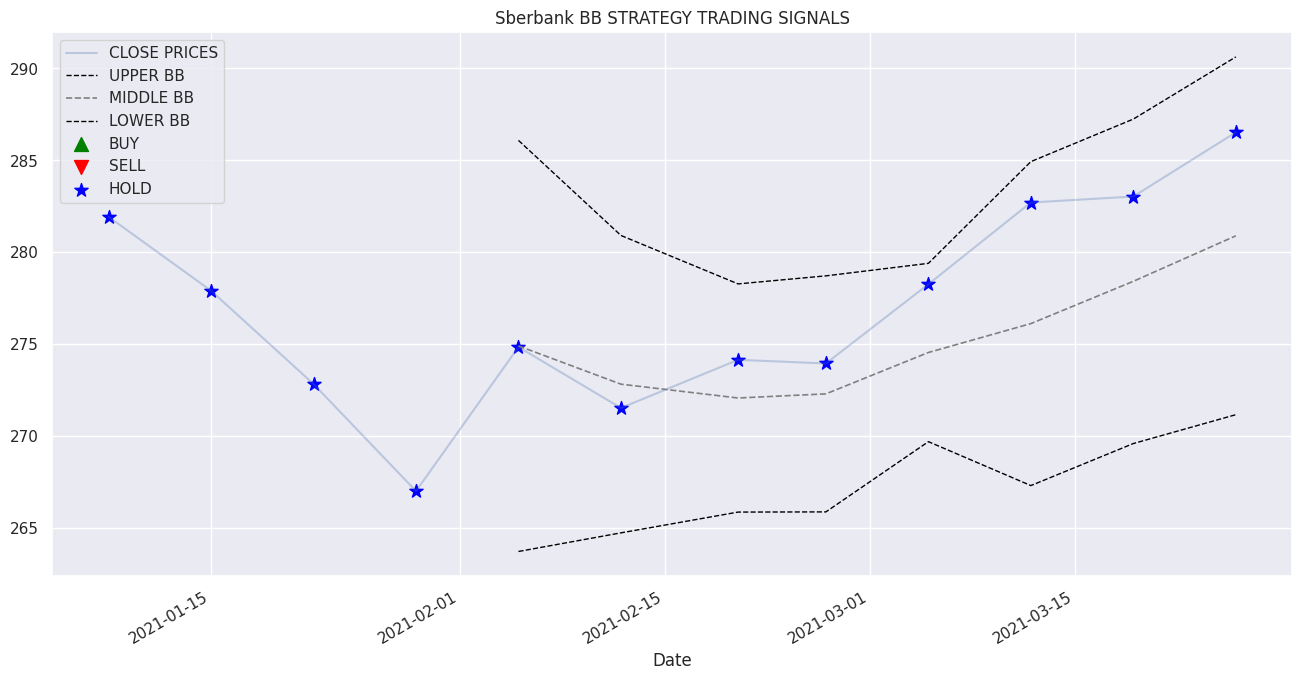

In [32]:
# here we found highest return with sma = 20 and bb = 20
df_final['sma'] = sma(df_final['Predicted Price'], 5)
df_final['upper_bb'], df_final['lower_bb'] = bb(df_final['Predicted Price'], df_final['sma'], 5)
buy_price, sell_price, hold_price, bb_signal = implement_bb_strategy(df_final)
# buy_price.insert(0, None)
# sell_price.insert(0, None)
# hold_price.insert(0, None)

plt.figure(figsize=(16, 8))
df_final['Predicted Price'].plot(label = 'CLOSE PRICES', alpha = 0.3)
df_final['upper_bb'].plot(label = 'UPPER BB', linestyle = '--', linewidth = 1, color = 'black')
df_final['sma'].plot(label = 'MIDDLE BB', linestyle = '--', linewidth = 1.2, color = 'grey')
df_final['lower_bb'].plot(label = 'LOWER BB', linestyle = '--', linewidth = 1, color = 'black')

plt.scatter(df_final.index, buy_price, marker = '^', color = 'green', label = 'BUY', s = 100)
plt.scatter(df_final.index, sell_price, marker = 'v', color = 'red', label = 'SELL', s = 100)
plt.scatter(df_final.index, hold_price, marker = '*', color = 'blue', label = 'HOLD', s = 100)
plt.title('{} BB STRATEGY TRADING SIGNALS'.format(data_name))
plt.legend(loc = 'upper left')
plt.show()